# Analisis Portofolio Kuantitatif: Modern Portfolio Theory & Efficient Frontier

**Penulis:** Muhammad Rizky Raihan
**Tanggal:** 11 Desember 2025
**Versi:** 1.0

---

## 1. Pendahuluan & Tujuan Proyek

Proyek ini bertujuan untuk membangun dan menganalisis portofolio saham menggunakan **Modern Portfolio Theory (MPT)**. MPT adalah kerangka kerja investasi yang dikembangkan oleh Harry Markowitz, yang menunjukkan bagaimana seorang investor dapat membangun portofolio optimal untuk memaksimalkan *expected return* berdasarkan tingkat risiko tertentu (diukur sebagai *variance* atau *standard deviation*).

**Tujuan Utama:**
1.  **Akuisisi Data:** Mengunduh data harga saham historis dari beberapa perusahaan teknologi besar.
2.  **Analisis Statistik:** Melakukan analisis statistik mendalam pada *logarithmic returns*, termasuk stasioneritas (Uji ADF) dan distribusi (Uji Jarque-Bera).
3.  **Kalkulasi MPT:** Menghitung *expected returns*, *covariance matrix*, *portfolio variance*, dan *portfolio returns*.
4.  **Simulasi Monte Carlo:** Menjalankan ribuan simulasi portofolio acak untuk memetakan *Efficient Frontier*.
5.  **Optimasi Portofolio:** Menemukan portofolio optimal secara matematis, termasuk:
    * **Sharpe Ratio Portfolio** (Portofolio dengan *return-to-risk* terbaik).
    * **Minimum Variance Portfolio** (Portofolio dengan risiko terendah).

**Konsep Matematika Inti:**
* **Portfolio Return ($R_p$):** $R_p = w^T \mu$
* **Portfolio Variance ($\sigma_p^2$):** $\sigma_p^2 = w^T \Sigma w$
* **Sharpe Ratio:** $\text{SR} = \frac{R_p - R_f}{\sigma_p}$

Di mana:
* $w$: Vektor bobot aset.
* $\mu$: Vektor *expected returns* aset.
* $\Sigma$: Matriks Kovariansi aset.
* $R_f$: *Risk-Free Rate*.

In [1]:
# Import library-library utama
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime

# Konfigurasi plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','NVDA', 'TSLA', 'META']
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')
RISK_FREE_RATE = 0.02
print("Parameters Configuration")
print(f"Tickers: {tickers}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Risk Free Rate: {RISK_FREE_RATE}")

Parameters Configuration
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META']
Start Date: 2020-11-12
End Date: 2025-11-12
Risk Free Rate: 0.02


## 2. Akuisisi & Persiapan Data

Pada fase ini, kita akan mengunduh data harga saham historis menggunakan library `yfinance`. 

Kita secara spesifik akan mengambil harga **'Adj Close' (Adjusted Close)**. Harga ini telah disesuaikan untuk *corporate actions* seperti pembagian dividen (*dividends*) dan pemecahan saham (*stock splits*), sehingga menjadikannya data yang akurat untuk menghitung *return* investasi historis.

In [3]:
try:
    print("Mengunduh data...")
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
    adj_close_df = data['Close']
    
    if adj_close_df.isnull().values.any():
        print("\nPERINGATAN: Ditemukan nilai NaN. Memeriksa...")
        print(adj_close_df.isnull().sum())
    else:
        print("\nData berhasil diunduh dan tidak ada nilai NaN.")

    print("\nData 'Close' (Adjusted) berhasil diunduh:")
    display(adj_close_df.head())
    
    print("\nMemeriksa tipe data dan nilai non-null:")
    adj_close_df.info()

except Exception as e:
    print(f"Error saat mengunduh data: {e}")

Mengunduh data...


[*********************100%***********************]  7 of 7 completed


Data berhasil diunduh dan tidak ada nilai NaN.

Data 'Close' (Adjusted) berhasil diunduh:


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2020-11-12,116.045242,155.514008,86.544098,273.394592,206.569336,13.415796,137.253326
2020-11-13,116.093918,156.440506,88.006012,275.253143,207.595291,13.256534,136.166672
2020-11-16,117.106323,156.552994,88.093903,277.250854,208.285645,13.474118,136.029999
2020-11-17,116.220482,156.783005,87.479645,273.315125,205.629700,13.381401,147.203339
2020-11-18,114.896576,155.272995,86.435844,270.303680,202.918716,13.387880,162.213333



Memeriksa tipe data dan nilai non-null:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-11-12 to 2025-11-11
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1255 non-null   float64
 1   AMZN    1255 non-null   float64
 2   GOOGL   1255 non-null   float64
 3   META    1255 non-null   float64
 4   MSFT    1255 non-null   float64
 5   NVDA    1255 non-null   float64
 6   TSLA    1255 non-null   float64
dtypes: float64(7)
memory usage: 78.4 KB


## 3. Analisis Data Eksploratif (EDA) & Statistik Return

Harga saham mentah (seperti yang kita lihat di atas) **tidak stasioner** (*non-stationary*). Artinya, rata-rata (mean) dan varians (variance) mereka berubah seiring waktu (mereka memiliki *trend* naik atau turun). Model MPT dan sebagian besar analisis deret waktu finansial tidak dapat bekerja langsung pada data yang tidak stasioner.

Oleh karena itu, kita harus mengubah data harga menjadi **return**. Kita akan menggunakan **Logarithmic Returns (Log Returns)** karena dua alasan utama:
1.  **Stasioneritas:** Log returns cenderung stasioner, yang memungkinkan kita menerapkan model statistik.
2.  **Aditif:** Log return bersifat aditif terhadap waktu. Log return selama seminggu adalah jumlah dari log return harian.

Formula untuk Log Return adalah:
$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$
Di mana $P_t$ adalah harga pada hari $t$ dan $P_{t-1}$ adalah harga pada hari sebelumnya.

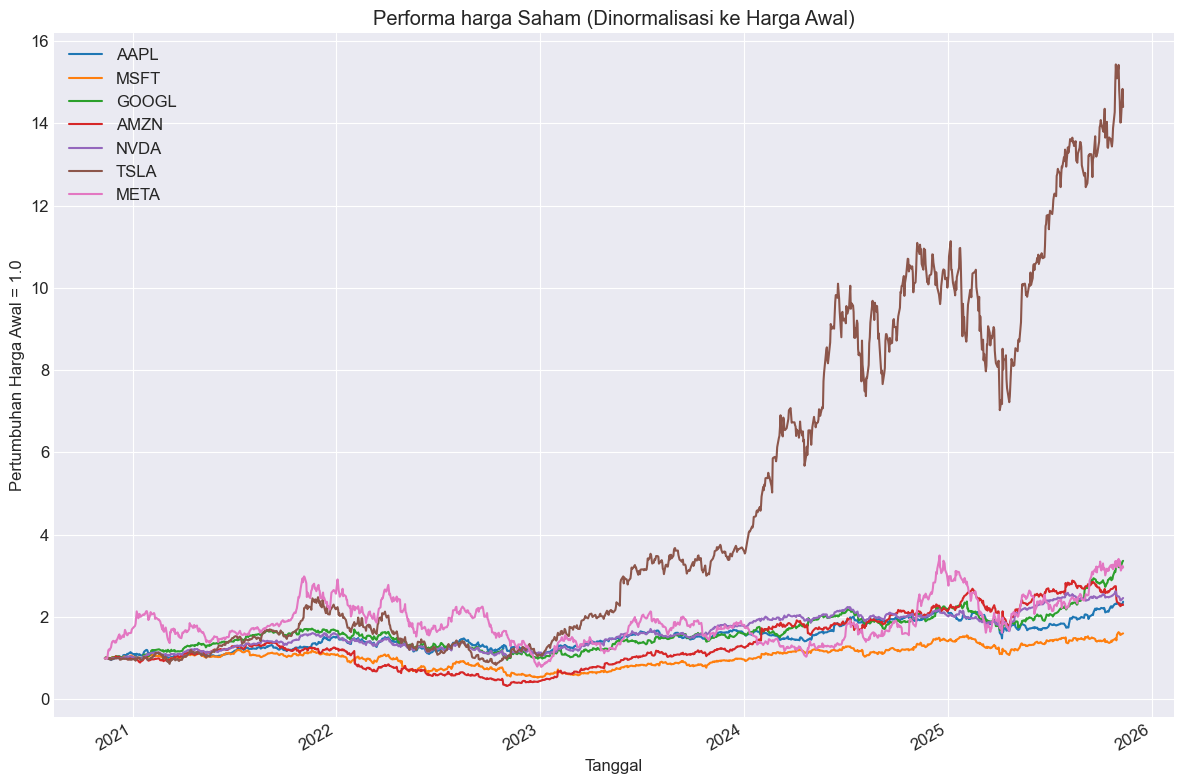


Log Returns Harian (5 baris pertama):
Ticker          AAPL      AMZN     GOOGL      META      MSFT      NVDA  \
Date                                                                     
2020-11-13  0.000419  0.005940  0.016751  0.006775  0.004954 -0.011942   
2020-11-16  0.008683  0.000719  0.000998  0.007232  0.003320  0.016280   
2020-11-17 -0.007593  0.001468 -0.006997 -0.014297 -0.012833 -0.006905   
2020-11-18 -0.011457 -0.009678 -0.012004 -0.011079 -0.013271  0.000484   
2020-11-19  0.005155  0.003716  0.010248  0.003560  0.006328  0.000856   

Ticker          TSLA  
Date                  
2020-11-13 -0.007949  
2020-11-16 -0.001004  
2020-11-17  0.078939  
2020-11-18  0.097097  
2020-11-19  0.025622  

Statistik Deskriptif Log Returns:


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,0.000689,0.000376,0.000968,0.000662,0.000719,0.002127,0.000928
std,0.017654,0.022048,0.019437,0.027617,0.016134,0.032540,0.038471
min,-0.097013,-0.151398,-0.099924,-0.306391,-0.080295,-0.185946,-0.167546
25%,-0.008056,-0.011009,-0.009484,-0.011582,-0.007421,-0.015906,-0.020263
50%,0.001139,0.000423,0.001536,0.000683,0.000706,0.002900,0.001477
75%,0.010054,0.012338,0.011311,0.013797,0.009868,0.021020,0.021985
max,0.142617,0.126949,0.097348,0.209308,0.096525,0.218088,0.204491


In [4]:
# 1. Plot harga 'Adj Close' mentah untuk melihat tren non-stasioner

(adj_close_df / adj_close_df.iloc[0]).plot(figsize=(12,8))
plt.title("Performa harga Saham (Dinormalisasi ke Harga Awal)")
plt.ylabel("Pertumbuhan Harga Awal = 1.0")
plt.xlabel("Tanggal")
plt.legend(tickers)
plt.tight_layout()
plt.show()

# 2. Menghitung return harian
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

# 3. Hapus Baris Pertama
log_returns = log_returns.dropna()

print("\nLog Returns Harian (5 baris pertama):")
print(log_returns.head())

print("\nStatistik Deskriptif Log Returns:")
display(log_returns.describe())

## 3.1. Uji Statistik Formal: Stasioneritas (ADF Test)

Kita telah mengubah harga menjadi *log returns* dengan hipotesis bahwa ini akan membuat data kita **stasioner**. Sekarang, kita harus *membuktikan* asumsi ini secara ilmiah.

Kita akan menggunakan **Augmented Dickey-Fuller (ADF) Test**, salah satu uji statistik paling umum untuk stasioneritas.

**Hipotesis Uji (ADF):**
* **$H_0$ (Hipotesis Nol):** Data *memiliki unit root* (yaitu, tidak stasioner).
* **$H_a$ (Hipotesis Alternatif):** Data *tidak memiliki unit root* (yaitu, stasioner).

**Tujuan Kita:** Kita ingin **menolak $H_0$**. Secara statistik, ini berarti kita mencari **p-value < 0.05**.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def run_adf_test(series, ticker_name):
    """
    Menjalankan ADF test pada series data dan mencetak hasilnya
    dengan format yang mudah dibaca.
    """
    print(f"--- Menganalisis {ticker_name} ---")
    
    result = adfuller(series, autolag='AIC')
    
    p_value = result[1]
    adf_statistic = result[0]
    
    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'P-value: {p_value:.6f}')
    
    if p_value < 0.05:
        print(f"Hasil: Stasioner (Menolak H0 pada signifikansi 5%)")
    else:
        print(f"Hasil: Tidak Stasioner (Gagal menolak H0 pada signifikansi 5%)")
    print("-" * 30)

print("Menjalankan Augmented Dickey-Fuller (ADF) Test pada Log Returns:")
for ticker in log_returns.columns:
    run_adf_test(log_returns[ticker], ticker)

Menjalankan Augmented Dickey-Fuller (ADF) Test pada Log Returns:
--- Menganalisis AAPL ---
ADF Statistic: -34.8244
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis AMZN ---
ADF Statistic: -35.9130
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis GOOGL ---
ADF Statistic: -21.8686
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis META ---
ADF Statistic: -35.9544
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis MSFT ---
ADF Statistic: -22.5975
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis NVDA ---
ADF Statistic: -21.4717
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis TSLA ---
ADF Stat

**ANALISIS**
- Temuan: Semua saham memiliki `p-value < 0.05`, yang berarti menolak $H_0$.
- Interpretasi: Karena `p-value < 0.05`, kita **Secara statistik menolak hipotesis nol ($H_0$)**.
- Kesimpulan: Log Returns bersifat **stasioner**.

---

## 3.2. Uji Statistik Formal: Normalitas (Jarque-Bera Test) & Visualisasi

Teori Portofolio Modern (MPT) klasik mengasumsikan bahwa *return* aset terdistribusi secara **normal** (yaitu, mengikuti *Gaussian distribution* atau "kurva lonceng").

Namun, dalam keuangan di dunia nyata, *return* seringkali menunjukkan:
1.  **Skewness:** Distribusi yang "miring" ke kiri atau kanan.
2.  **Kurtosis (Leptokurtosis):** Distribusi yang lebih "runcing" dengan "ekor gemuk" (*fat tails*), yang berarti peristiwa ekstrem (pergerakan harga besar) terjadi lebih sering daripada yang diprediksi oleh distribusi normal.

Kita akan menguji ini secara visual dengan **Histogram** dan secara statistik dengan **Jarque-Bera (JB) Test**.

**Hipotesis Uji (Jarque-Bera):**
* **$H_0$ (Hipotesis Nol):** Data terdistribusi normal (Skewness = 0, Kurtosis = 3).
* **$H_a$ (Hipotesis Alternatif):** Data *tidak* terdistribusi normal.

**Tujuan Kita:** Kita *menduga* akan **menolak $H_0$** (p-value < 0.05), yang membuktikan bahwa *return* saham tidak normal sempurna.

Menjalankan Jarque-Bera Test pada Log Returns:


,Ticker,JB Statistic,P-Value,Skewness,Kurtosis,Is Normal (α=0.05)
0,AAPL,1483.745958,0.000000e+00,0.251198,8.305153,False
1,AMZN,1437.795379,0.000000e+00,-0.092854,8.242435,False
2,GOOGL,541.194569,3.027559e-118,-0.063423,6.215852,False
3,META,36961.113162,0.000000e+00,-1.219916,29.484655,False
4,MSFT,484.634957,5.792369e-106,0.084847,6.040808,False
5,NVDA,726.773830,1.524292e-158,0.228158,6.701530,False
6,TSLA,307.787527,1.461462e-67,0.088120,5.420663,False


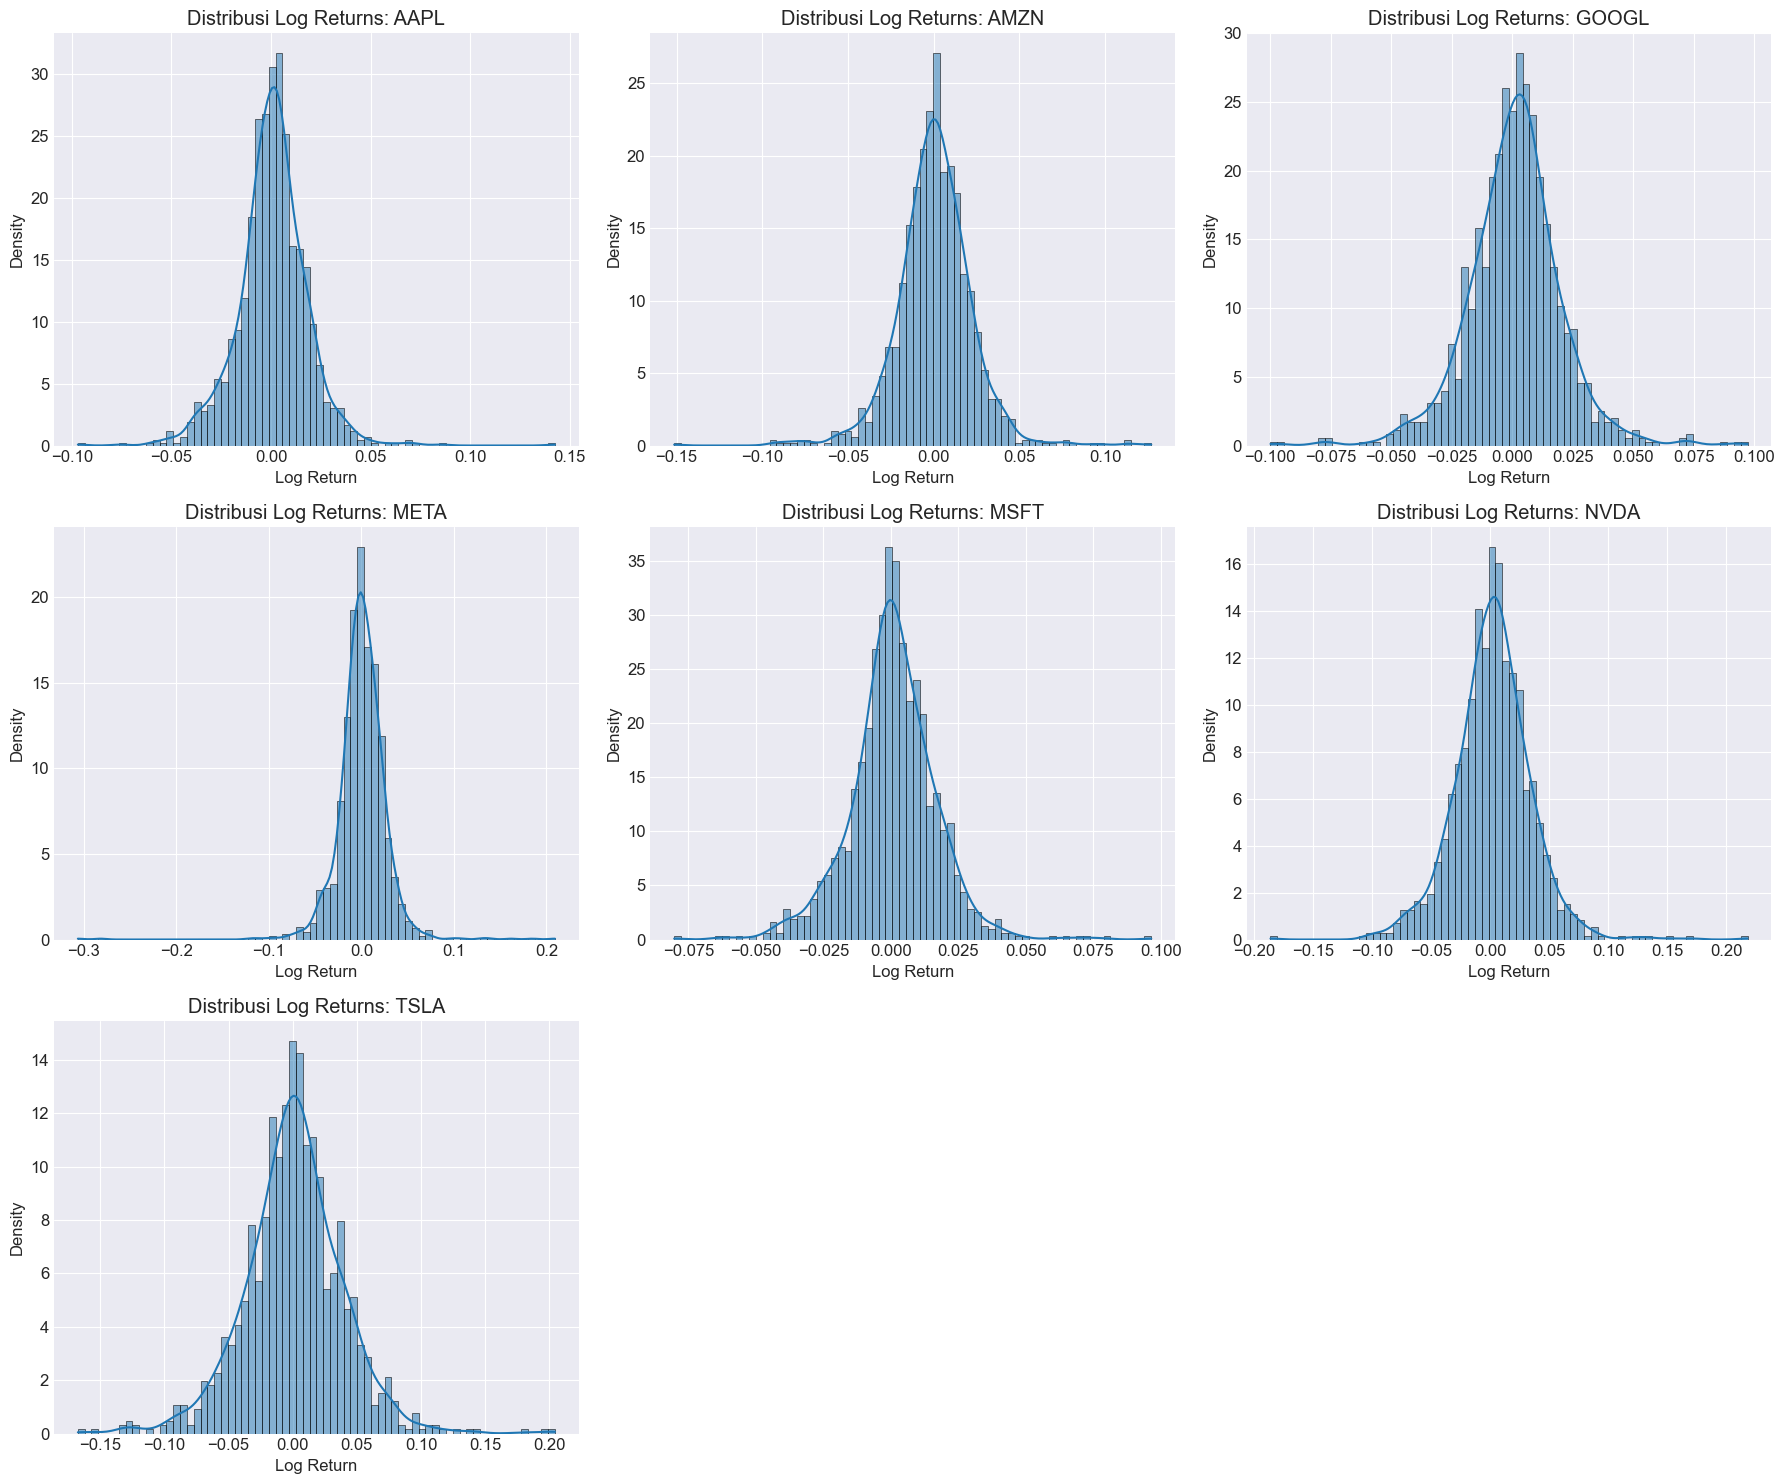

In [ ]:
from statsmodels.stats.stattools import jarque_bera

print("Menjalankan Jarque-Bera Test pada Log Returns:")

jb_results = []

for ticker in log_returns.columns:
  returns_data = log_returns[ticker]
  
  jb_stat, jb_pvalue, skew, kurt = jarque_bera(returns_data)
  
  jb_results.append({
      'Ticker': ticker,
      'JB Statistic': jb_stat,
      'P-Value': jb_pvalue,
      'Skewness': skew,
      'Kurtosis': kurt,
      'Is Normal (α=0.05)': jb_pvalue > 0.05
  })
  
jb_df = pd.DataFrame(jb_results)
display(jb_df)

#Visualisasi Distribusi Log Returns
fig, axes = plt.subplots(3,3, figsize=(18, 15), sharex=False, sharey=False)

axes_flat = axes.flatten()

for i, ticker in enumerate(log_returns.columns):
  ax = axes_flat[i]
  sns.histplot(log_returns[ticker], kde=True, bins=70, ax=ax, stat="density")
  ax.set_title(f'Distribusi Log Returns: {ticker}')
  ax.set_xlabel('Log Return')
  ax.set_ylabel('Density')
  
  for i in range(len(log_returns.columns), len(axes_flat)):
    axes_flat[i].set_visible(False)
    
plt.tight_layout()
plt.show()

**ANALISIS**
- Temuan (Tabel): Sebagian besar saham memiliki `p-value < 0.05`, yang berarti menolak $H_0$.
- Temuan (Statistik): `Kurtosis` untuk semua saham secara signifikan lebih besar dari 3, pada `META` yang memiliki kurtosis ekstrim `29.48`, menunjukkan fat tails yang kuat. `skewness` ada pada `~ -1.22`, menunjukkan kemiringan negatif yang kuat.
- Interpretasi: Karena `p-value < 0.05` untuk sebagian besar saham, kita **Secara statistik menolak hipotesis nol ($H_0$)**.
- Kesimpulan: Data Log Returns **tidak terdistribusi normal**. Secara spesifik, data ini bersifat **leptokurtik** (lebih runcing di tengah dan memiliki fat tails).

---

## 4. Perhitungan Komponen Modern Portfolio Theory (MPT)

Setelah menyelesaikan EDA, kita sekarang akan menghitung dua komponen utama yang diperlukan untuk MPT:

1.  **Expected Annualized Returns ($\mu$):** Rata-rata *return* yang kita harapkan dari setiap aset selama satu tahun.
2.  **Annualized Covariance Matrix ($\Sigma$):** Matriks yang mengukur bagaimana setiap aset bergerak relatif terhadap satu sama lain dalam basis tahunan. Ini adalah "mesin" dari diversifikasi.

Data `log_returns` kita saat ini dalam basis *harian*. Kita harus mengkonversinya ke basis *tahunan* (annualized) agar bermakna. Kita akan mengasumsikan ada **252 hari perdagangan** dalam setahun (angka standar industri).

**Formula:**
* **Annualized Return:** $R_{\text{annual}} = \text{mean}(r_{\text{daily}}) \times 252$
* **Annualized Covariance:** $\Sigma_{\text{annual}} = \text{Cov}(r_{\text{daily}}) \times 252$

In [ ]:
# Asumsi 252 hari perdagangan dalam setahun
TRADING_DAYS = 252

# 1. Hitung Expected Annualized Returns (mu)
mu = log_returns.mean() * TRADING_DAYS

print("Expected Annualized Returns (mu):")
print("(Ini adalah komponen R_p = w^T * mu)")
display(mu)

# 2. Hitung Annualized Covariance Matrix (Sigma)
Sigma = log_returns.cov() * TRADING_DAYS

print("\nAnnualized Covariance Matrix (Sigma):")
print("(Ini adalah komponen sigma_p^2 = w^T * Sigma * w)")
display(Sigma)

Expected Annualized Returns (mu):
(Ini adalah komponen R_p = w^T * mu)


Ticker
AAPL     0.173566
AMZN     0.094675
GOOGL    0.243908
META     0.166826
MSFT     0.181099
NVDA     0.535969
TSLA     0.233930
dtype: float64


Annualized Covariance Matrix (Sigma):
(Ini adalah komponen sigma_p^2 = w^T * Sigma * w)


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Ticker,,,,,,,
AAPL,0.078535,0.054960,0.050193,0.059441,0.045646,0.074798,0.083291
AMZN,0.054960,0.122499,0.067143,0.091786,0.059176,0.101343,0.093943
GOOGL,0.050193,0.067143,0.095204,0.076254,0.052052,0.084628,0.076089
META,0.059441,0.091786,0.076254,0.192204,0.065898,0.111813,0.090700
MSFT,0.045646,0.059176,0.052052,0.065898,0.065600,0.083440,0.065083
NVDA,0.074798,0.101343,0.084628,0.111813,0.083440,0.266830,0.146949
TSLA,0.083291,0.093943,0.076089,0.090700,0.065083,0.146949,0.372962


### 4.1. Analisis Korelasi (Kunci Diversifikasi)

Kovariansi adalah inti dari risiko portofolio. Sebuah ukuran yang lebih mudah dipahami adalah **korelasi**, yang memberitahu kita *arah* dan *kekuatan* hubungan antar aset.

$$\rho_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j}$$

* $\rho = 1$: Korelasi positif sempurna (aset bergerak bersama).
* $\rho = -1$: Korelasi negatif sempurna (aset bergerak berlawanan).
* $\rho = 0$: Tidak ada korelasi.

**Tujuan Diversifikasi:** Kita ingin menggabungkan aset yang memiliki korelasi rendah (atau idealnya negatif) untuk mengurangi risiko portofolio secara keseluruhan.

Kita akan memvisualisasikan matriks korelasi menggunakan **heatmap**.

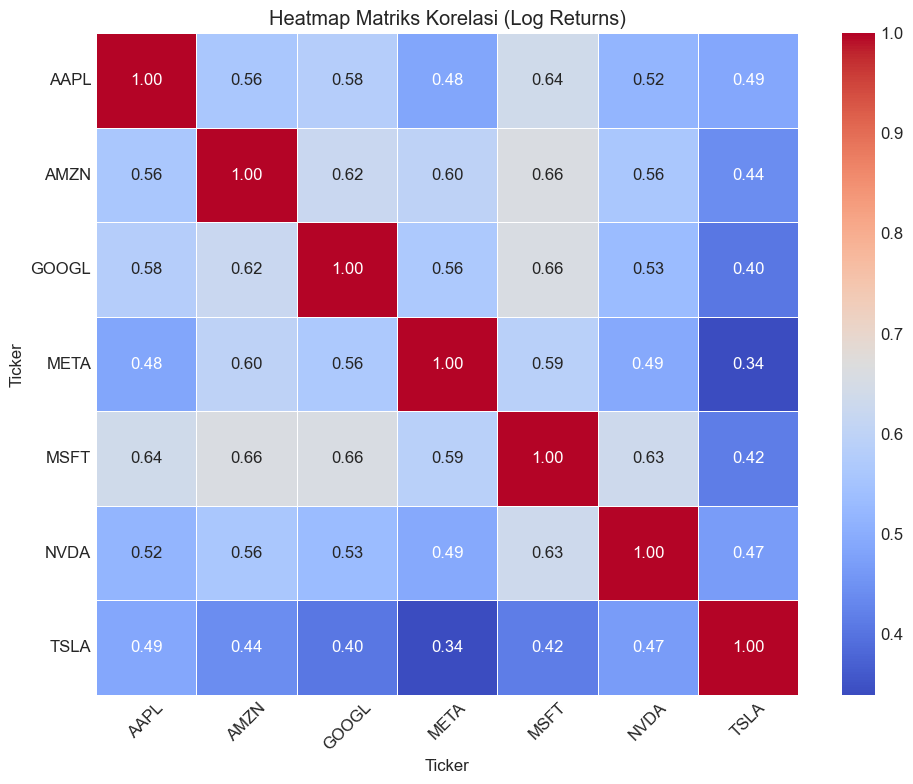

In [ ]:
# Hitung Correlation Matrix (tidak perlu dikalikan 252, karena normalisasi)
corr_matrix = log_returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,        
    cmap='coolwarm',   
    fmt='.2f',         
    linewidths=0.5
)
plt.title('Heatmap Matriks Korelasi (Log Returns)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Analisis Output (Diagnosis)

Output yang dihasilkan menunjukkan konsistensi metodologis dan validitas empiris. Dengan demikian, "bahan-bahan" untuk penerapan **Modern Portfolio Theory (MPT)** telah tersedia.

### Expected Annualized Returns (μ)

Berdasarkan data historis 5 tahun terakhir, diperoleh vektor ekspektasi return tahunan (μ) sebagai berikut:

- **NVDA**: 0.535969 (≈ 53.6%) → return tertinggi.
- **TSLA**: 23.4%.
- **GOOGL**: 24.4%.
- **AMZN**: 9.4% → return terendah.

Interpretasi: NVDA memiliki potensi return paling tinggi, sementara AMZN menunjukkan tingkat return paling rendah. Vektor ini menjadi dasar dalam formulasi optimasi portofolio.

### Annualized Covariance Matrix (Σ)

Matriks kovarians tahunan berukuran 7x7 berfungsi sebagai komponen utama dalam MPT.  

- **Diagonal (Varians)**:  
  Nilai diagonal merepresentasikan varians (risiko) masing-masing aset.  
  - Contoh: AAPL–AAPL = 0.078.  
  - TSLA–TSLA = 0.372962 dan NVDA–NVDA = 0.266830 → varians tertinggi, menandakan risiko relatif lebih besar.

- **Off-Diagonal (Kovarians)**:  
  Nilai non-diagonal menunjukkan kovarians antar aset.  
  - Contoh: AAPL–AMZN = 0.054960 → menunjukkan tingkat keterkaitan pergerakan kedua aset.  

Dengan demikian, matriks Σ menjadi representasi kuantitatif atas struktur risiko dan hubungan antar aset.

### Heatmap Korelasi

Visualisasi korelasi antar aset menunjukkan pola penting bagi strategi diversifikasi.

- **Interpretasi Kunci**:  
  Tidak ditemukan korelasi negatif. Semua nilai berada pada rentang 0.34–0.66, menandakan kecenderungan pergerakan searah antar saham teknologi (karena homogenitas sektor).

- **Diversifikasi Terbaik**:  
  Pasangan dengan korelasi terendah adalah **TSLA–META (0.34)**.

- **Diversifikasi Terburuk**:  
  Pasangan dengan korelasi tertinggi adalah **MSFT–GOOGL (0.66)** atau **MSFT–AMZN (0.66)**, menunjukkan keterkaitan pergerakan yang sangat dekat.

### Kesimpulan

Portofolio yang dibentuk dari aset-aset ini tidak mampu mengeliminasi risiko secara total. Namun, melalui optimasi komposisi aset, dimungkinkan untuk memaksimalkan return yang diharapkan sesuai dengan tingkat risiko yang dapat ditoleransi. Hal ini sejalan dengan prinsip dasar MPT, yaitu pencapaian **efisiensi portofolio** melalui keseimbangan antara return dan risiko.

---

## 5. Simulasi Portofolio (Monte Carlo)

Dengan komponen $\mu$ (expected returns) dan $\Sigma$ (covariance matrix) yang telah kita hitung, kita sekarang dapat mensimulasikan ribuan portofolio yang berbeda. Setiap portofolio akan memiliki kombinasi bobot (weights) $w$ yang acak untuk 7 aset kita.

Untuk setiap portofolio $i$, kita akan menghitung tiga metrik utama:

1.  **Portfolio Return ($R_p$):** $R_{p,i} = w_i^T \mu$
2.  **Portfolio Volatility ($\sigma_p$):** $\sigma_{p,i} = \sqrt{w_i^T \Sigma w_i}$
3.  **Sharpe Ratio ($SR$):** $\text{SR}_i = \frac{R_{p,i} - R_f}{\sigma_{p,i}}$

Kita akan menjalankan simulasi ini (misalnya, 100.000 kali) untuk menghasilkan peta dari semua kemungkinan *risk-return tradeoff*. Kumpulan portofolio yang optimal dari simulasi ini akan membentuk **Efficient Frontier**.

In [ ]:
NUM_PORTFOLIOS = 100_000
num_assets = len(tickers)

portfolio_results = []

for i in range(NUM_PORTFOLIOS):
    # 1. Hasilkan bobot acak
    weights = np.random.random(num_assets)
    # 2. Normalisasi bobot agar jumlahnya = 1
    weights = weights / np.sum(weights)
    
    # 3. Hitung Portfolio Return (Annualized)
    # R_p = w^T * mu
    port_return = np.sum(mu * weights)
    
    # 4. Hitung Portfolio Variance (Annualized)
    # sigma_p^2 = w^T * Sigma * w
    port_variance = np.dot(weights.T, np.dot(Sigma, weights))
    
    # 5. Hitung Portfolio Volatility (StDev)
    port_volatility = np.sqrt(port_variance)
    
    # 6. Hitung Sharpe Ratio
    # SR = (R_p - R_f) / sigma_p
    sharpe_ratio = (port_return - RISK_FREE_RATE) / port_volatility
    
    # 7. Simpan hasil
    # Kita simpan bobot sebagai dict untuk kemudahan pembacaan nanti
    portfolio_results.append({
        'Return': port_return,
        'Volatility': port_volatility,
        'SharpeRatio': sharpe_ratio,
        'Weights': weights
    })

print(f"Simulasi {NUM_PORTFOLIOS} portofolio selesai.")

Simulasi 100000 portofolio selesai.


In [ ]:
results_df = pd.DataFrame(portfolio_results)

weights_df = pd.DataFrame(
    results_df['Weights'].to_list(),
    columns=tickers
)

sim_portfolios_df = pd.concat([results_df, weights_df], axis=1)

sim_portfolios_df = sim_portfolios_df.drop('Weights', axis=1)

print("DataFrame Hasil Simulasi Portofolio (termasuk bobot):")
display(sim_portfolios_df.head())

print("\nInfo DataFrame:")
sim_portfolios_df.info()

DataFrame Hasil Simulasi Portofolio (termasuk bobot):


,Return,Volatility,SharpeRatio,AAPL,MSFT,GOOGL,AMZN,NVDA,TSLA,META
0,0.204463,0.259573,0.710638,0.267020,0.146728,0.173156,0.058298,0.264434,0.076937,0.013428
1,0.218953,0.273197,0.728239,0.326994,0.028114,0.016631,0.024210,0.378199,0.099706,0.126146
2,0.246238,0.325492,0.695066,0.065156,0.172038,0.005359,0.141173,0.223730,0.203410,0.189135
3,0.260989,0.350364,0.687825,0.135978,0.129306,0.090410,0.089651,0.056910,0.203266,0.294479
4,0.185561,0.330667,0.500688,0.230348,0.279586,0.101038,0.057092,0.004170,0.024872,0.302894



Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Return       100000 non-null  float64
 1   Volatility   100000 non-null  float64
 2   SharpeRatio  100000 non-null  float64
 3   AAPL         100000 non-null  float64
 4   MSFT         100000 non-null  float64
 5   GOOGL        100000 non-null  float64
 6   AMZN         100000 non-null  float64
 7   NVDA         100000 non-null  float64
 8   TSLA         100000 non-null  float64
 9   META         100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


## 6. Visualisasi Efficient Frontier (Hasil Monte Carlo)

Kita sekarang memiliki 100.000 portofolio acak. Kita akan memplotnya pada grafik 2D untuk memvisualisasikan **Efficient Frontier**.

* **Sumbu X (Risk):** `Volatility` (Standard Deviation)
* **Sumbu Y (Return):** `Return`
* **Warna (Color):** `SharpeRatio` (Semakin tinggi/terang warnanya, semakin baik portofolio tersebut)

"Efficient Frontier" adalah kurva di tepi kiri atas dari "awan" titik-titik ini. Titik-titik pada kurva ini mewakili portofolio yang menawarkan *return* tertinggi untuk *tingkat risiko tertentu*.

Kita akan secara spesifik menemukan dan menandai dua portofolio kunci dari simulasi kita:
1.  **Portofolio Sharpe Ratio Maksimum (Max SR):** Portofolio yang memberikan *return-to-risk* terbaik.
2.  **Portofolio Volatilitas Minimum (Min Vol):** Portofolio teraman dengan risiko absolut terendah.

--- Portofolio Sharpe Ratio Maksimum (Best Risk-Adjusted Return) ---
Return      : 37.96%
Volatility  : 36.94%
Sharpe Ratio: 0.97

--- Portofolio Volatilitas Minimum (Safest Portfolio) ---
Return      : 18.75%
Volatility  : 24.38%
Sharpe Ratio: 0.69


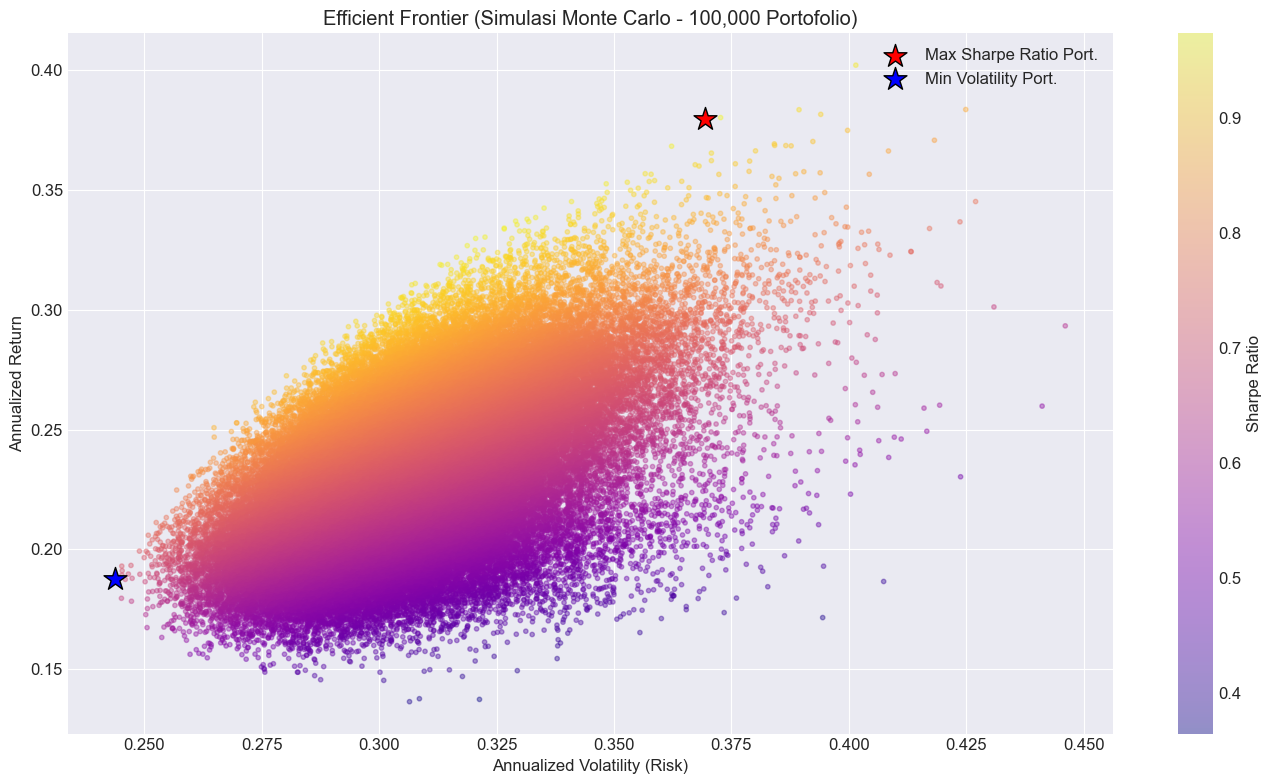

In [ ]:
max_sharpe_port = sim_portfolios_df.iloc[sim_portfolios_df['SharpeRatio'].idxmax()]

min_vol_port = sim_portfolios_df.iloc[sim_portfolios_df['Volatility'].idxmin()]

print("--- Portofolio Sharpe Ratio Maksimum (Best Risk-Adjusted Return) ---")
print(f"Return      : {(max_sharpe_port['Return'] * 100):.2f}%")
print(f"Volatility  : {(max_sharpe_port['Volatility'] * 100):.2f}%")
print(f"Sharpe Ratio: {max_sharpe_port['SharpeRatio']:.2f}")

print("\n--- Portofolio Volatilitas Minimum (Safest Portfolio) ---")
print(f"Return      : {(min_vol_port['Return'] * 100):.2f}%")
print(f"Volatility  : {(min_vol_port['Volatility'] * 100):.2f}%")
print(f"Sharpe Ratio: {min_vol_port['SharpeRatio']:.2f}")


plt.figure(figsize=(14, 8))

plt.scatter(
    sim_portfolios_df['Volatility'],
    sim_portfolios_df['Return'],
    c=sim_portfolios_df['SharpeRatio'],
    cmap='plasma',
    alpha=0.4,
    s=10
)

plt.colorbar(label='Sharpe Ratio')

plt.scatter(
    max_sharpe_port['Volatility'],
    max_sharpe_port['Return'],
    marker='*',
    color='red',
    s=300,
    edgecolor='black',
    label='Max Sharpe Ratio Port.'
)

plt.scatter(
    min_vol_port['Volatility'],
    min_vol_port['Return'],
    marker='*',
    color='blue',
    s=300,
    edgecolor='black',
    label='Min Volatility Port.'
)

plt.title('Efficient Frontier (Simulasi Monte Carlo - 100,000 Portofolio)')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Analisis Komposisi Portofolio Optimal

Visualisasi yang ditampilkan sebelumnya menunjukkan posisi portofolio optimal dalam spektrum **risk-return**. Pada bagian ini, dilakukan analisis terhadap komposisi bobot (allocation weights) dari dua portofolio utama yang dihasilkan melalui optimasi.

### Portofolio Max Sharpe Ratio
Portofolio ini merepresentasikan strategi bagi investor dengan preferensi **agresif**, yaitu mereka yang berorientasi pada pencapaian rasio *return-to-risk* tertinggi.  
- Bobot aset ditentukan untuk memaksimalkan **Sharpe Ratio**, sehingga portofolio ini memberikan efisiensi optimal dalam konteks trade-off antara return dan risiko.  
- Secara teoritis, portofolio ini sesuai dengan prinsip **mean-variance optimization**, di mana utilitas investor meningkat seiring dengan peningkatan rasio imbal hasil terhadap volatilitas.

### Portofolio Min Volatility
Portofolio ini ditujukan bagi investor dengan preferensi **konservatif**, yaitu mereka yang memprioritaskan stabilitas dan risiko terendah.  
- Bobot aset disusun untuk meminimalkan **total variance** portofolio.  
- Portofolio ini menghasilkan tingkat risiko paling rendah, meskipun ekspektasi return tidak setinggi portofolio Max Sharpe Ratio.  
- Strategi ini relevan bagi investor dengan toleransi risiko minimal, yang lebih mengutamakan **preservasi modal** dibandingkan pertumbuhan agresif.

### Kesimpulan
Analisis komposisi bobot menunjukkan bahwa:
- **Investor agresif** cenderung memilih **Portofolio Max Sharpe Ratio** untuk memperoleh efisiensi return yang maksimal.  
- **Investor konservatif** lebih sesuai dengan **Portofolio Min Volatility**, karena memberikan stabilitas dengan risiko yang lebih terkendali.  

Dengan demikian, pemilihan portofolio optimal bergantung pada **profil risiko investor**, yang menjadi variabel kunci dalam penerapan Modern Portfolio Theory (MPT).

Alokasi Bobot Portofolio Optimal (FIXED):


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Max Sharpe Ratio,11.38%,1.50%,17.70%,7.69%,6.09%,53.38%,2.25%
Min Volatility,37.75%,3.36%,7.30%,0.76%,47.05%,1.88%,1.90%


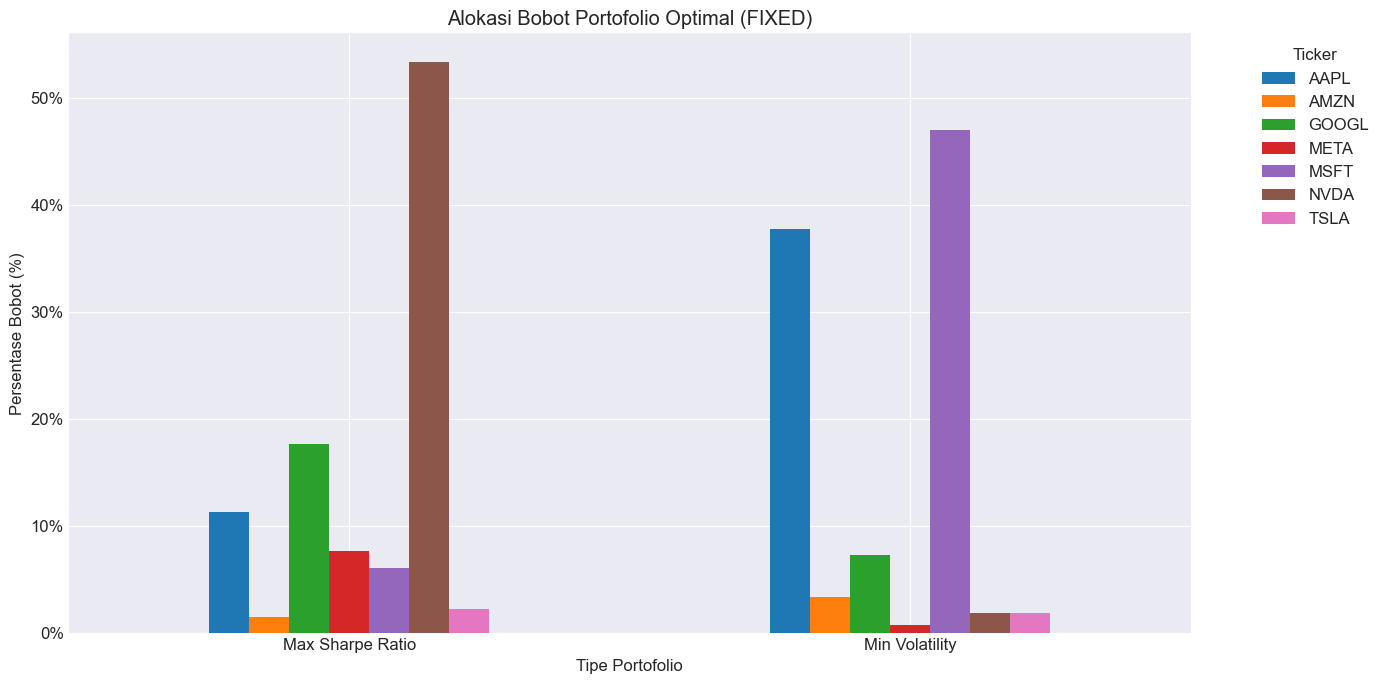

In [19]:
correct_order = log_returns.columns.to_list()

buggy_order = tickers 

max_sharpe_weights_raw = max_sharpe_port.loc[buggy_order]
min_vol_weights_raw = min_vol_port.loc[buggy_order]

max_sharpe_weights_FIXED = pd.Series(
    max_sharpe_weights_raw.values, 
    index=correct_order, 
    name='Max Sharpe Ratio'
)

min_vol_weights_FIXED = pd.Series(
    min_vol_weights_raw.values, 
    index=correct_order, 
    name='Min Volatility'
)

optimal_weights_df_FIXED = pd.DataFrame(
    [max_sharpe_weights_FIXED, min_vol_weights_FIXED]
)

print("Alokasi Bobot Portofolio Optimal (FIXED):")
display(optimal_weights_df_FIXED.map(lambda x: f"{(x*100):.2f}%"))


optimal_weights_df_FIXED.plot(
    kind='bar', 
    figsize=(14, 7)
)
plt.title('Alokasi Bobot Portofolio Optimal (FIXED)')
plt.ylabel('Persentase Bobot (%)')
plt.xlabel('Tipe Portofolio')
plt.xticks(rotation=0)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 8. Optimasi Portofolio Matematis (menggunakan SciPy)

Simulasi Monte Carlo sangat baik untuk memvisualisasikan ribuan kemungkinan, tetapi itu adalah *perkiraan* (brute-force). Untuk menemukan portofolio yang **benar-benar optimal** secara matematis, kita akan menggunakan *solver* optimasi numerik dari `scipy.optimize`.

Kita akan menyelesaikan dua masalah optimasi:

**1. Portofolio Sharpe Ratio Maksimum:**
* **Tujuan:** Menemukan vektor bobot $w$ yang *memaksimalkan* Sharpe Ratio.
* **Masalah Optimasi:** *Solver* hanya dapat *meminimalkan* sebuah fungsi. Oleh karena itu, kita akan memintanya untuk **meminimalkan Negative Sharpe Ratio**.
    $$\text{minimize} \left( - \frac{R_p - R_f}{\sigma_p} \right) = \text{minimize} \left( - \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}} \right)$$

**2. Portofolio Volatilitas Minimum:**
* **Tujuan:** Menemukan vektor bobot $w$ yang *meminimalkan* volatilitas (risiko).
* **Masalah Optimasi:**
    $$\text{minimize} (\sigma_p) = \text{minimize} \left( \sqrt{w^T \Sigma w} \right)$$

**Kendala (Constraints) & Batasan (Bounds):**
Untuk kedua masalah, *solver* harus mematuhi dua aturan:
1.  **Kendala (Constraint):** Total bobot harus berjumlah 1 (100%). $\sum_{i=1}^{n} w_i = 1$
2.  **Batasan (Bounds):** Bobot untuk setiap aset harus antara 0 dan 1 (0% dan 100%). Kita tidak mengizinkan *short selling* (bobot negatif). $0 \le w_i \le 1$

In [ ]:
# Fungsi pembantu untuk optimasi

def get_portfolio_metrics(weights, mu, Sigma, risk_free_rate):
    """
    Menghitung return, volatilitas, dan sharpe ratio untuk
    satu set bobot portofolio.
    """
    # R_p = w^T * mu
    port_return = np.sum(mu * weights)
    
    # sigma_p^2 = w^T * Sigma * w
    port_variance = np.dot(weights.T, np.dot(Sigma, weights))
    
    # sigma_p
    port_volatility = np.sqrt(port_variance)
    
    # SR
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    
    return port_return, port_volatility, sharpe_ratio


def negative_sharpe_ratio(weights, mu, Sigma, risk_free_rate):
    """
    Fungsi objektif untuk diminimalkan (Negative SR).
    """
    return -get_portfolio_metrics(weights, mu, Sigma, risk_free_rate)[2]


def portfolio_volatility(weights, mu, Sigma, risk_free_rate):
    """
    Fungsi objektif untuk diminimalkan (Volatility).
    """
    return get_portfolio_metrics(weights, mu, Sigma, risk_free_rate)[1]

print("Fungsi-fungsi pembantu untuk optimasi telah didefinisikan.")

Fungsi-fungsi pembantu untuk optimasi telah didefinisikan.


In [ ]:
# --- Menyiapkan Optimasi ---
num_assets = len(correct_order) # Menggunakan urutan kolom yang benar

# 1. Tentukan Kendala (Constraint)
# 'type': 'eq' berarti "equality" (persamaan)
# 'fun': lambda... adalah fungsi yang harus dievaluasi menjadi 0.
# Kita ingin np.sum(weights) - 1 = 0
constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# 2. Tentukan Batasan (Bounds)
bounds = tuple((0.0, 1.0) for _ in range(num_assets))

# 3. Tentukan Tebakan Awal (Initial Guess)
# Menggunakan bobot yang merata (1/n) untuk memulai
initial_guess = np.array(num_assets * [1. / num_assets])

# --- Menjalankan Optimasi #1: Max Sharpe Ratio ---
print("Menjalankan optimasi untuk Max Sharpe Ratio...")
# 'SLSQP' (Sequential Least Squares Programming) adalah solver yang baik
# untuk masalah optimasi non-linear dengan kendala.
opt_sharpe_result = minimize(
    negative_sharpe_ratio,  # Fungsi untuk diminimalkan
    initial_guess,          # Tebakan awal
    args=(mu, Sigma, RISK_FREE_RATE), # Argumen tambahan untuk fungsi
    method='SLSQP',
    bounds=bounds,
    constraints=constraint
)

# --- Menjalankan Optimasi #2: Min Volatility ---
print("Menjalankan optimasi untuk Min Volatility...")
opt_vol_result = minimize(
    portfolio_volatility,   # Fungsi untuk diminimalkan
    initial_guess,
    args=(mu, Sigma, RISK_FREE_RATE), # args tidak terlalu penting di sini tapi baik untuk konsistensi
    method='SLSQP',
    bounds=bounds,
    constraints=constraint
)

print("Optimasi selesai.")

Menjalankan optimasi untuk Max Sharpe Ratio...
Menjalankan optimasi untuk Min Volatility...
Optimasi selesai.


In [23]:
# Ekstrak bobot optimal dari hasil
opt_sharpe_weights = opt_sharpe_result.x
opt_vol_weights = opt_vol_result.x

# Dapatkan metrik untuk portofolio hasil optimasi
opt_sharpe_metrics = get_portfolio_metrics(opt_sharpe_weights, mu, Sigma, RISK_FREE_RATE)
opt_vol_metrics = get_portfolio_metrics(opt_vol_weights, mu, Sigma, RISK_FREE_RATE)

# --- Tampilkan Hasil (FIXED FORMATTING) ---

# 1. Tampilkan Metrik
opt_metrics_df = pd.DataFrame({
    'Metric': ['Return', 'Volatility', 'Sharpe Ratio'],
    'Max Sharpe (SciPy)': opt_sharpe_metrics,
    'Min Volatility (SciPy)': opt_vol_metrics
}).set_index('Metric')

print("\n--- Hasil Metrik Portofolio (Optimasi Matematis) ---")
# Gunakan format persentase untuk Return/Vol, dan desimal untuk Sharpe
opt_metrics_df.loc['Return'] = opt_metrics_df.loc['Return'].map('{:.2%}'.format)
opt_metrics_df.loc['Volatility'] = opt_metrics_df.loc['Volatility'].map('{:.2%}'.format)
opt_metrics_df.loc['Sharpe Ratio'] = opt_metrics_df.loc['Sharpe Ratio'].map('{:.4f}'.format)
display(opt_metrics_df)


# 2. Tampilkan Bobot
opt_weights_df = pd.DataFrame({
    'Ticker': correct_order,
    'Max Sharpe (SciPy)': opt_sharpe_weights,
    'Min Volatility (SciPy)': opt_vol_weights
}).set_index('Ticker')

print("\n--- Hasil Bobot Portofolio (Optimasi Matematis) ---")
display(opt_weights_df.map(lambda x: f"{(x*100):.2f}%"))


# 3. Tampilkan Perbandingan
print("\n--- Perbandingan dengan Hasil Monte Carlo ---")
mc_max_sharpe_metrics = (
    max_sharpe_port['Return'], 
    max_sharpe_port['Volatility'], 
    max_sharpe_port['SharpeRatio']
)
mc_min_vol_metrics = (
    min_vol_port['Return'], 
    min_vol_port['Volatility'], 
    min_vol_port['SharpeRatio']
)

comparison_df = pd.DataFrame({
    'Max Sharpe (SciPy)': opt_sharpe_metrics,
    'Max Sharpe (Monte Carlo)': mc_max_sharpe_metrics,
    'Min Vol (SciPy)': opt_vol_metrics,
    'Min Vol (Monte Carlo)': mc_min_vol_metrics
}, index=['Return', 'Volatility', 'Sharpe Ratio'])

# Gunakan format desimal .4f yang konsisten untuk perbandingan
display(comparison_df.map(lambda x: f"{x:.4f}"))


--- Hasil Metrik Portofolio (Optimasi Matematis) ---


C:\Users\Raihan\AppData\Local\Temp\ipykernel_24284\2835068990.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.44%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  opt_metrics_df.loc['Return'] = opt_metrics_df.loc['Return'].map('{:.2%}'.format)
C:\Users\Raihan\AppData\Local\Temp\ipykernel_24284\2835068990.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.69%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  opt_metrics_df.loc['Return'] = opt_metrics_df.loc['Return'].map('{:.2%}'.format)


,Max Sharpe (SciPy),Min Volatility (SciPy)
Metric,,
Return,43.44%,18.69%
Volatility,40.43%,23.91%
Sharpe Ratio,1.0251,0.6980



--- Hasil Bobot Portofolio (Optimasi Matematis) ---


,Max Sharpe (SciPy),Min Volatility (SciPy)
Ticker,,
AAPL,0.00%,33.19%
AMZN,0.00%,0.00%
GOOGL,34.76%,13.20%
META,0.00%,0.00%
MSFT,0.00%,53.61%
NVDA,65.24%,0.00%
TSLA,0.00%,0.00%



--- Perbandingan dengan Hasil Monte Carlo ---


,Max Sharpe (SciPy),Max Sharpe (Monte Carlo),Min Vol (SciPy),Min Vol (Monte Carlo)
Return,0.4344,0.3796,0.1869,0.1875
Volatility,0.4043,0.3694,0.2391,0.2438
Sharpe Ratio,1.0251,0.9735,0.6980,0.6870


## 9. Kesimpulan & Temuan Akhir Proyek

Proyek ini berhasil melakukan analisis optimasi portofolio *end-to-end* dengan menggunakan **Modern Portfolio Theory (MPT)** pada 7 saham teknologi utama selama periode 5 tahun terakhir. Analisis ini mencakup tahap eksplorasi data, pengujian asumsi statistik, serta penerapan metode simulasi dan optimasi matematis.

### Temuan Kunci Ilmiah

1. **Analisis Statistik (EDA):**  
   - Data harga saham mentah terbukti **tidak stasioner** (dikonfirmasi melalui tren visual).  
   - Data **Log Returns** terbukti **stasioner** (dikonfirmasi oleh **Uji ADF** dengan p-value < 0.05), sehingga valid untuk pemodelan kuantitatif.

2. **Asumsi Normalitas:**  
   - Distribusi Log Returns terbukti **tidak normal** (dikonfirmasi oleh **Uji Jarque-Bera** dengan p-value < 0.05).  
   - Data bersifat **leptokurtik** (memiliki *fat tails*), yang mengimplikasikan frekuensi kejadian ekstrem lebih tinggi dibandingkan prediksi distribusi normal.

3. **Monte Carlo vs. Optimasi Matematis:**  
   - Simulasi **Monte Carlo (100.000 iterasi)** memberikan visualisasi yang komprehensif atas *Efficient Frontier* dan menghasilkan estimasi akurat untuk Portofolio Volatilitas Minimum.  
   - *Solver* **Optimasi Matematis (`SciPy`)** berhasil menemukan solusi portofolio optimal secara eksak, dengan hasil yang **mengungguli** estimasi Monte Carlo pada Portofolio Sharpe Ratio Maksimum (SR: **1.025** vs **0.974**).

### Hasil Akhir Portofolio Optimal (SciPy)

#### 1. Portofolio Volatilitas Minimum (Konservatif)
- **Tujuan:** Meminimalkan risiko total.  
- **Metrik:** Return = `18.69%`, Volatilitas = `23.91%`, Sharpe Ratio = `0.698`.  
- **Alokasi Bobot:**  
  - `MSFT`: 53.61%  
  - `AAPL`: 33.19%  
  - `GOOGL`: 13.20%  

#### 2. Portofolio Sharpe Ratio Maksimum (Efisien)
- **Tujuan:** Memaksimalkan rasio *return-to-risk*.  
- **Metrik:** Return = `43.44%`, Volatilitas = `40.43%`, Sharpe Ratio = `1.025`.  
- **Alokasi Bobot:**  
  - `NVDA`: 65.24%  
  - `GOOGL`: 34.76%  

### Kesimpulan Umum
Hasil penelitian menunjukkan bahwa:
- Portofolio konservatif (Min Volatility) lebih sesuai bagi investor dengan toleransi risiko rendah.  
- Portofolio efisien (Max Sharpe Ratio) memberikan imbal hasil relatif lebih tinggi dengan risiko yang lebih besar, sesuai bagi investor agresif.  

Secara keseluruhan, penerapan MPT pada saham teknologi ini menegaskan pentingnya **trade-off antara return dan risiko**, serta menunjukkan keunggulan metode optimasi matematis dibandingkan simulasi Monte Carlo dalam menemukan portofolio yang benar-benar optimal.